# Image Processing SS 20 - Assignment - 03

### Deadline is 13.5.2020 at 11:55am

Please solve the assignments together with a partner.
I will run every notebook. Make sure the code runs through. Select `Kernel` -> `Restart & Run All` to test it.
Please strip the output from the cells, either select `Cell` -> `All Output` -> `Clear` or use the `nb_strip_output.py` script / git hook.

In [1]:
# display the plots inside the notebook
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pylab
import ssl
from urllib.request import urlopen
from skimage.data import astronaut
from skimage.color import rgb2gray, rgb2hsv, hsv2rgb
import math 

pylab.rcParams['figure.figsize'] = (12, 12)   # This makes the plot bigger

In [3]:
img = astronaut() / 255.
img_hsv = rgb2hsv(img)
img_gray = rgb2gray(img)

# Exercise 1 - Implement a Histogram Mapping - 1 Points

In [4]:
def norm_cdf(arr):
    return arr / arr[-1]

In [5]:
def gamma_mapping(gamma):
    """
    Returns a 1-dimensional numpy array. The value of the array at the n-position 
    is `(n/len(array))**gamma`.
    """
    return norm_cdf(np.linspace(0, 1, 255)**gamma)


def sigmoid_mapping(gain = 10, cutoff = 0.5):
    """
    Returns a 1-dimensional numpy array. The value of the array at the n-position 
    is  `1/(1 + exp*(gain*(cutoff - (n/len(array)))))`.
    """
    array = np.zeros(255)
    for n in range(255):
        array[n] = 1/(1 + math.exp(gain*(cutoff - (n/len(array)))))
    return norm_cdf(array)

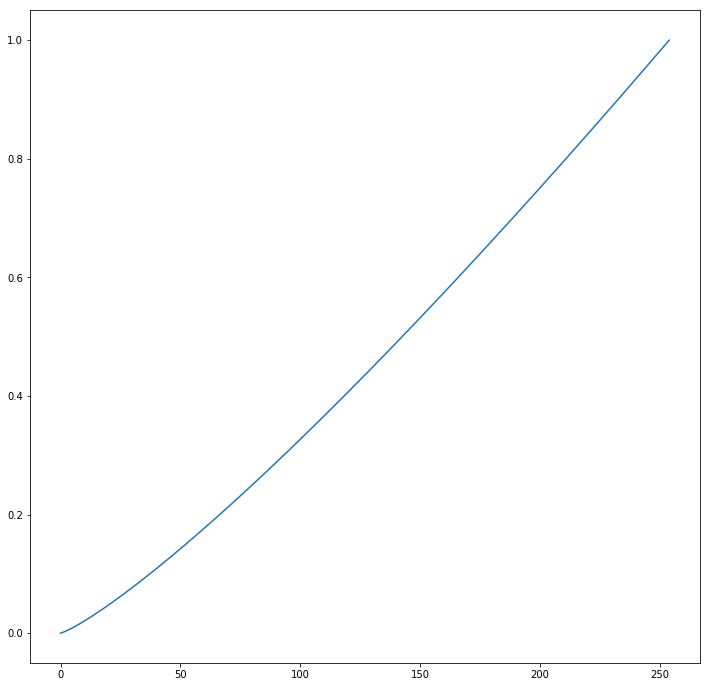

In [6]:
plt.plot(gamma_mapping(1.2))
plt.show()

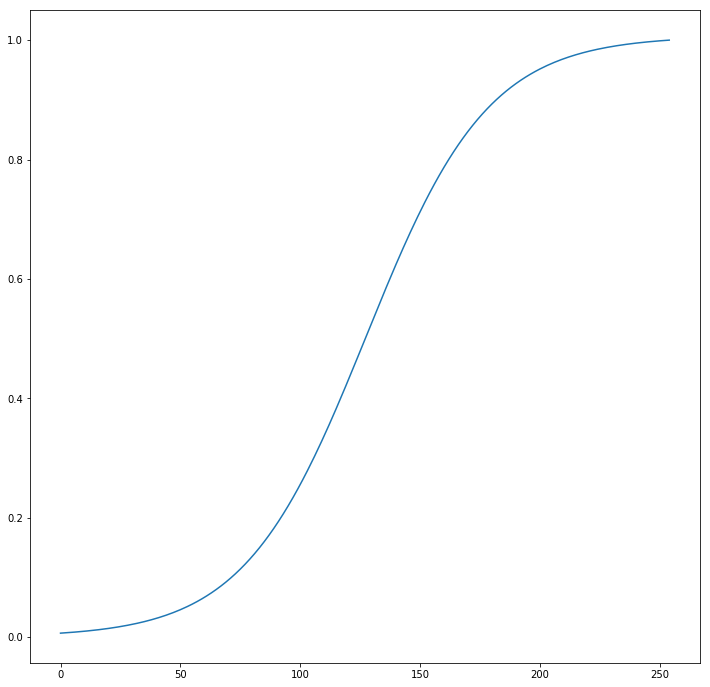

In [7]:
plt.plot(sigmoid_mapping())
plt.show()

# Exercise 2 - Histogram Transformation - 2 Points

In [8]:
def apply_pixel_mapping(image, mapping):
    """Returns the image transformed according to the mapping array. 
       `mapping` is a one dimensional numpy array. `image` can be 2 or 3-dimensional.
       The values of the image are in range 0 to 1. 
       If the mapping has for example 255 items, then all pixel with a value from 0 to 1/255 are assigned to 
       the value mapping[0]. If the pixel is between n / 255 and (n+1) / 255 then the value in the output image should 
       be mapping[n]
    """
    x,y = image.shape
    mappedArray = np.zeros_like(image)
    for i in range(x):
       for j in range(y):
          index = int(image[i,j] * len(mapping)) 
          if(index == len(mapping) ):
             index = len(mapping) - 1
          mappedArray[i,j] = mapping[index]
    return mappedArray

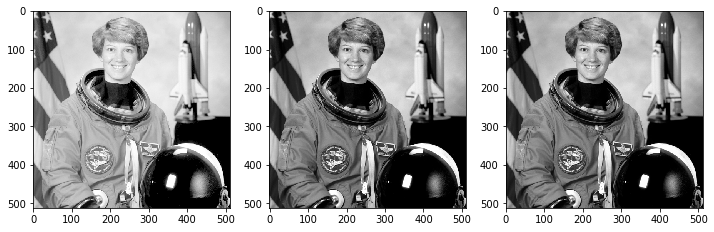

In [9]:
# you can test your `apply_pixel_mapping` function
# The first image should look lighter. The second and third should be the same image.
img_gamma05 = apply_pixel_mapping(img_gray, gamma_mapping(0.5))
plt.subplot(131)
plt.imshow(img_gamma05, cmap='gray')
plt.subplot(132)
img_gamma2 = apply_pixel_mapping(img_gamma05, gamma_mapping(2))  
plt.imshow(img_gamma2, cmap='gray')
plt.subplot(133)
plt.imshow(img_gray, cmap='gray')
plt.show()

# Exercise 3 - Implement Histogram Equalisation - 2 Points

Equalize the image given image so that the histogram is mostly uniform distributed.
You can use `np.histogram` and `np.cumsum`. Checkout the documentation of `np.histogram`, it might have useful optional arguments.

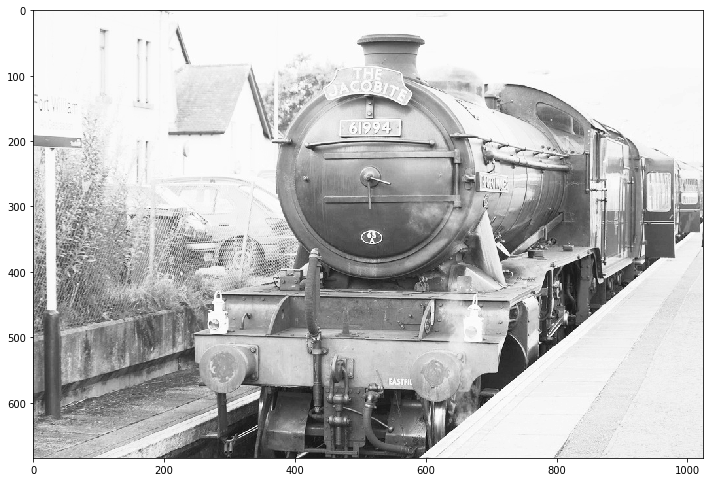

In [10]:
# bypass certficate check here since there are sometimes problems with urllib
ssl._create_default_https_context = ssl._create_unverified_context
f = urlopen("https://dl.dropboxusercontent.com/s/ahj4nff6ba8b8sg/lok.jpg?dl=0")
train = rgb2gray(plt.imread(f, format='jpeg'))
plt.imshow(train, cmap='gray')
plt.show()

In [11]:
def histogram_equalization(img):
    hist, bin_edges = np.histogram(img.flatten(), bins=256, range=(0,1) , density=True ) # get the histogram of the image
    cdf = np.cumsum(hist)
    return hist, cdf


In [12]:
hist, cdf = histogram_equalization(train)
img_equalised = apply_pixel_mapping(train, cdf)

In [13]:
hist_of_equalised, bin_edges = np.histogram(img_equalised.flatten(), bins=256 , density=True ) # get the histogram of the equalised image
hist_of_equalised            = hist_of_equalised * np.diff(bin_edges)

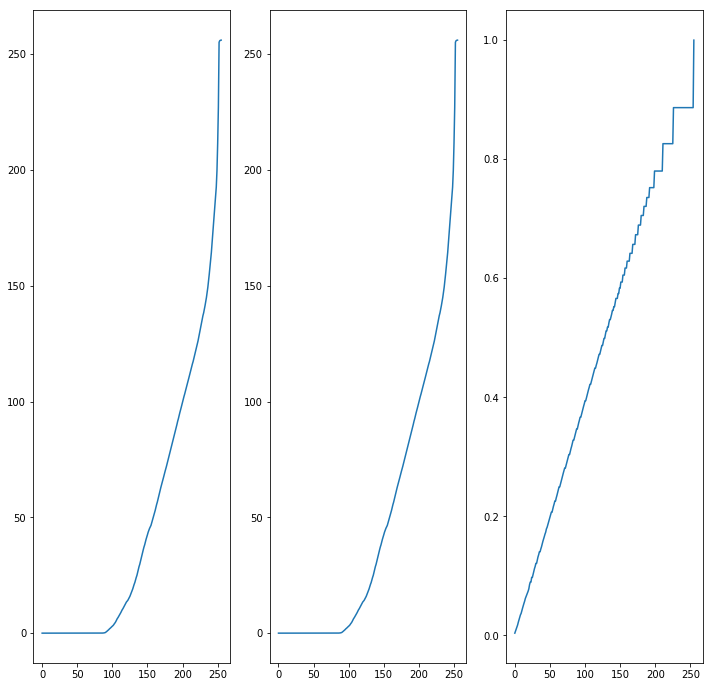

In [14]:
plt.subplot(131)
plt.plot(hist.cumsum())
plt.subplot(132)
plt.plot(cdf)
plt.subplot(133)
plt.plot(hist_of_equalised.cumsum())
plt.show()

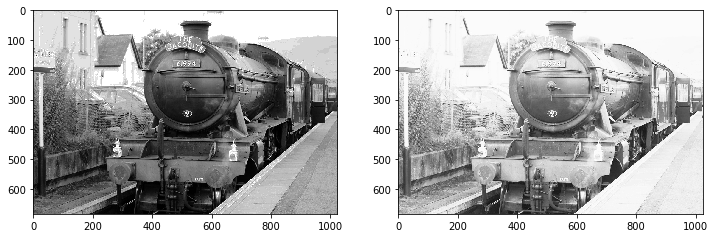

In [15]:
plt.subplot(121)
plt.imshow(img_equalised, cmap='gray')
plt.subplot(122)
plt.imshow(train, cmap='gray')
plt.show()

# Exercise 4 - Implement a hipster filter - 2 Points

1. Convert the image to HSV 
1. Transform the V-Channel with `sigmoid_mapping` and gain = 10.
1. Transform the S-Channel with `sigmoid_mapping` and gain = 10, cufoff=0.35
1. Convert it back to RGB and add the color hsv(0.05, 1, 1) weighted by $0.5\cdot(1 - V)$ to the image, where V is the resulting V-Channel from step 2.

You can test the code with your own image or the `astronaut()` test image.
If you choose a custom image, you can included it through the `urllib` library as done with the lok image.
You can use the `rgb2hsv` and `hsv2rgb` functions from the skimage library.

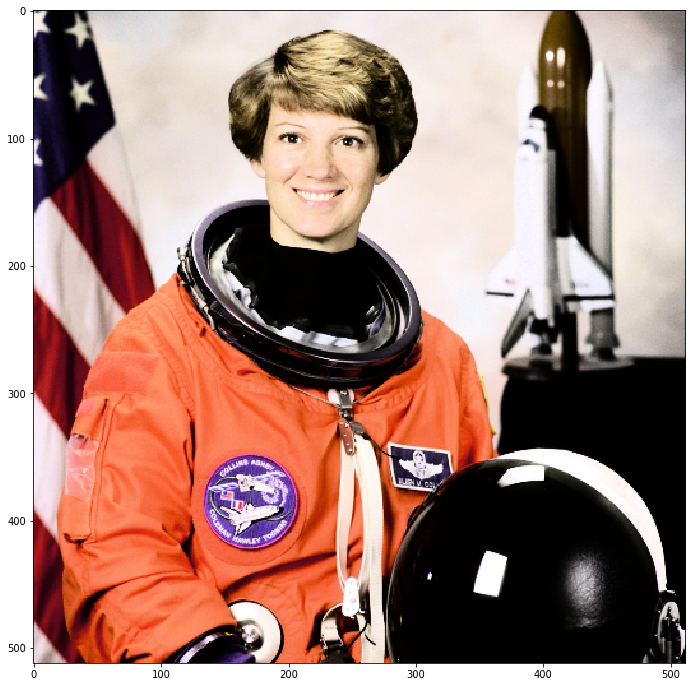

In [16]:
img_hsv = rgb2hsv(img) 
img_v = img_hsv

v_channel = apply_pixel_mapping(img_hsv[:,:,(2)] , sigmoid_mapping(gain=10))
img_v[:,:,(2)] = v_channel  
 
plt.imshow( hsv2rgb(img_v))
plt.show()

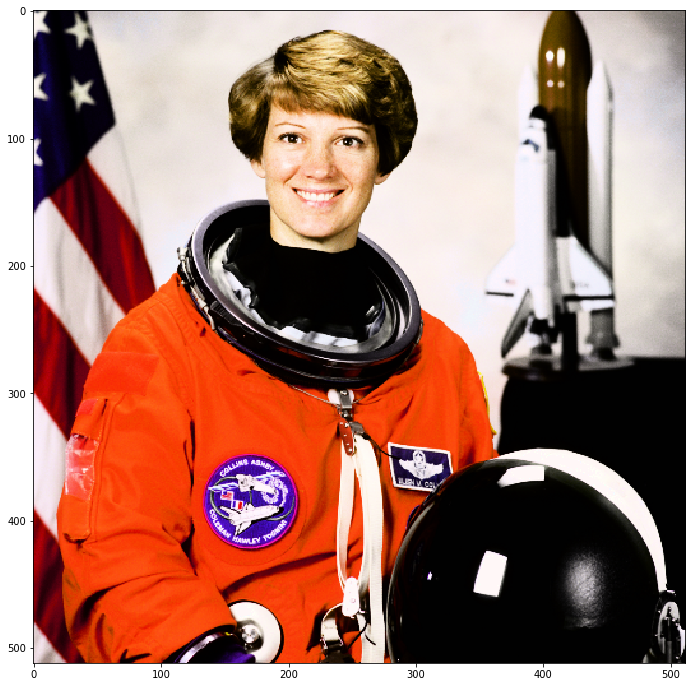

In [17]:
s_channel = apply_pixel_mapping(img_v[:,:,(1)] , sigmoid_mapping(gain=10,cutoff=0.35) )
img_v [:,:,(1)] = s_channel

 
plt.imshow( hsv2rgb(img_v))
plt.show()

Convert it back to RGB and add the color hsv(0.05, 1, 1) weighted by  0.5(1−V)  to the image, where V is the resulting V-Channel from step 2.

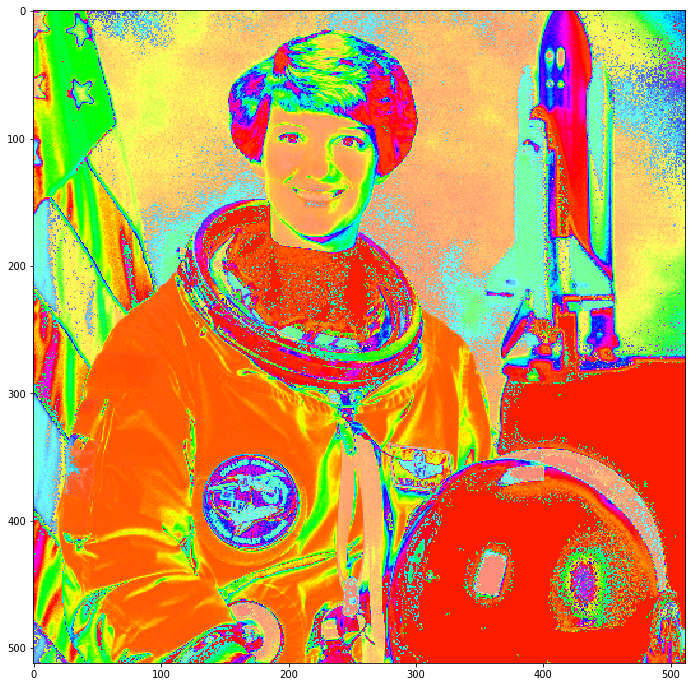

In [18]:
img3 = img_v
x,y,_ = img3.shape
for i in range(x):
    for j in range(y):
        h,s,v = img3[i,j,0],img3[i,j,1],img3[i,j,2]
        h =  (h+0.05)* 0.5+(1-v)
        s = (s+1) * 0.5+(1-v)
        v = (v+1) * 0.5+(1-v)
        if h < 0:
            h = h + 360
        if s > 1:
            s = 1
        if v > 1:
            v = 1
        img3[i,j] = np.array([h,s,v])
plt.imshow(hsv2rgb(img3))    
plt.show()

# Exercise 5 - Implement your own hipster filter - 3 Points

You have mostly complete artistic freedom in this exercise. 
The filter should not be trivial. Converting the image only to grayscale is not enough ;) 
You should show off your knowledge of histogram transformations. (Use at least 2 histogram transformations)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


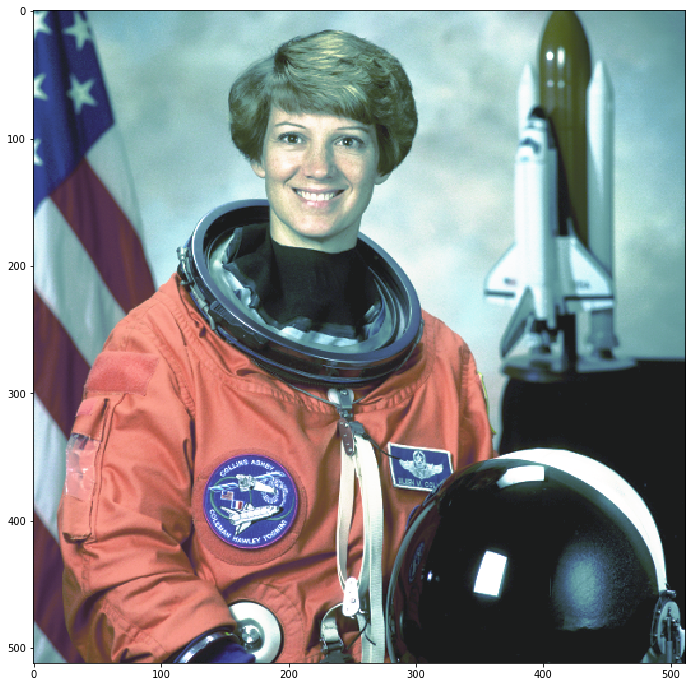

In [19]:
r_channel, g_channel, b_channel = img[:,:,0],img[:,:,1],img[:,:,2]

_,cdf_r  = histogram_equalization(r_channel)
_,cdf_g  = histogram_equalization(g_channel)
_,cdf_b  = histogram_equalization(b_channel)

new_img = np.zeros_like(img)

img_equalised_r = apply_pixel_mapping(r_channel, cdf_r)
img_equalised_g = apply_pixel_mapping(g_channel, cdf_g)
img_equalised_b = apply_pixel_mapping(b_channel, cdf_b)
 

new_img[:,:,0] = img_equalised_r
new_img[:,:,1] = img_equalised_g
new_img[:,:,2] = img_equalised_b

plt.imshow( new_img/255 )  
plt.show()